## Evoluční algoritmy
- nejprve si ukážeme příklad evolučního algoritmu pro řešení problému batohu (konkrétně 0-1 knapsack problem)
    - položky jsou předměty $x_i$ s vahou $w_i$ a cenou $c_i$
    - cílem problému je vybrat z pevně danné množiny $n$ položek jejich podmnožinu $I$ tak, že:
        1. váha vybraných položek je menší rovna kapacitě W batohu $$\sum_{I}{w_i} \le W$$
        2. zároveň se snažíme maximalizovat jejich cenu $$\max \sum_{I}{c_i}$$
- problém lze řešit řadou typů algoritmů (greedy, dynamicky, bruteforce)

In [ ]:
# Nejprve ukázka klasického řešení pomocí Greedy algoritmu
# V kazdé iteraci se vybere aktuálně nejvýhodnější možnost – instance, která neporuší podmínku váhy a zároveň přidá největší cenu
def greedy_knapsack(instances: list, bound: int) -> list:
    # Seřazení podle ceny instancí – O(nlogn)
    instances = sorted(instances, key=lambda i: i[2], reverse=True)

    # Aktuální kapacita
    knapsack_capacity = 0
    # Vybrané instance
    solution = []
    while len(instances):
        i = instances.pop(0)
        id, w, _ = i

        if knapsack_capacity + w <= bound:
            knapsack_capacity += w
            solution.append(id)

        if knapsack_capacity == bound:
            break

    return solution

In [2]:
# Instanci reprezentuji jako trojici (id, váha, cena)
instances = [(0, 7, 5), (1, 3, 4), (2, 5, 7), (3, 9, 6)]
print("Instances:", instances)

Instances: [(0, 7, 5), (1, 3, 4), (2, 5, 7), (3, 9, 6)]


In [3]:
knapsack_capacity = 15
idx = greedy_knapsack(instances, knapsack_capacity)

print("Greedy Algorithm result:")
for i in idx:
    print(instances[i])

Greedy Algorithm result:
(2, 5, 7)
(3, 9, 6)


Je výsledek greedy algoritmu optimum?

## Evoluční proces
- pro jednoduchost využijeme pseudokódu od doc. Konečného

In [ ]:
import random

class GeneticKnapsack():
    def __init__(self, instances, knapsack_capacity):
        self.instances = instances
        self.knapsack_capacity = knapsack_capacity
        self.initial_population_size = 4

        # Pravděpodobnost s jakou dojde k mutaci
        self.mutation_rate = 0.01
        
        # Pravděpodobnost s jakou dojde k rekombinaci (křížení) genetické informace
        self.crossover_rate = 0.5

        # Pravděpodobnost s jakou dojde k reprodukci, tj. proces předávání jedince v nezměněné podobě z jedné generace do druhé bez mutace nebo křížení 
        self.reproduction_rate = 0.30
        self.reproduction_count = 2

    def next_generation(self, population):
        next_gen = []
        while len(next_gen) < len(population):
            # Přirozený výběr (selekce)
            parents = self.selection(population)

            # Reprodukce
            if random.random() < self.reproduction_rate:
                p = sorted(population, key=lambda i: self.fitness(i), reverse=True)
                next_gen.extend(p[:self.reproduction_count])

            # Rekombinace
            if random.random() < self.crossover_rate:
                child1, child2 = self.crossover(parents[0], parents[1])

                # Mutace
                candidate1 = self.mutation(child1)
                candidate2 = self.mutation(child2)
            else:
                candidate1 = parents[0]
                candidate2 = parents[1]
                
            next_gen.append(candidate1) 
            next_gen.append(candidate2) 

        return next_gen[:len(population)]
    
    def evolution(self):
        time_step = 0
        population = self.generate_initial_population()

        # Naše ukončovací podmínka je stanovena na pevný počet iterací.
        while time_step < 500:
            time_step += 1
            population = self.next_generation(population)

        population = sorted(population, key=lambda i: self.fitness(i), reverse=True)
        best_instance = population[0]

        result = []
        for i in range(len(instances)):
            if best_instance[i] == '1':
                result.append(i)
        return result

    def generate_initial_population(self):
        "Vytvoří count počet počátečních kandidátu, každý ve formě n bitových řetězců, kde n je počet instancí."
        population = set()
        # Počet instancí
        n = len(self.instances)

        # Tvorba kandidáta
        while len(population) < self.initial_population_size:
            candidate = ''.join(random.choice('01') for _ in range(n))
            population.add(candidate)
        
        return list(population)

    def fitness(self, individual):
        "Vrací fitness kandidáta jako součet všech cen vybraných instancí."
        candidate_weight = 0
        candidate_cost = 0

        # Funkce zip funguje následovně: zip([1, 2], ["a", "b"]) –> [[1, "a"], [2, "b"]]
        for gene, instance in zip(individual, self.instances):
            if gene == '1':
                candidate_weight += instance[1]
                candidate_cost += instance[2]
                if candidate_weight > self.knapsack_capacity:
                    # Nekorektní řešení, protože součet vah kandidáte převýšil kapacitu batohu.
                    return 0  
        return candidate_cost
    
    def selection(self, population):
        "Vybere dva kandidáty z populace pomocí turnajového výběru"
        parents = []
        random.shuffle(population)

        if len(population) < 4:
            # Vyber nějaké dva pokud je populace malá.
            return population[:2]
        
        # turnajový výběr mezi prvním a druhým
        a = population[0]
        b = population[1]
        if self.fitness(a) > self.fitness(b):
            parents.append(a)
        else:
            parents.append(b)

        # turnajový výběr mezi třetím a čtvrtým
        c = population[2]
        d = population[3]
        if self.fitness(c) > self.fitness(d):
            parents.append(c)
        else:
            parents.append(d)

        return parents

    def crossover(self, parent1, parent2):
        "Jednoduché rovnoměrné křížení mezi dvěma rodiči. Opět lze řešit různými způsoby: single-point crossover, two-point crossover, multi-point crossover, uniform crossover a nebo arithmetic crossover"
        n = len(parent1)
        middle = n // 2
        child1 = parent1[:middle] + parent2[middle:]
        child2 = parent2[:middle] + parent1[middle:]
        return child1, child2
    
    def mutation(self, individual):
        "Mutace kandidáta s danou pravděpodobností mutace."
        individual = list(individual)
        for i in range(len(individual)):
            # Random.random() vrací číslo z intervalu [0, 1) 
            if random.random() < self.mutation_rate:
                individual[i] = '1' if individual[i] == '0' else '0'
        return ''.join(individual)

In [238]:
knapsack_capacity = 15

idx = GeneticKnapsack(instances, knapsack_capacity).evolution()

print("Genetic Algorithm result:")
for i in idx:
    print(instances[i])

Genetic Algorithm result:
(0, 7, 5)
(1, 3, 4)
(2, 5, 7)


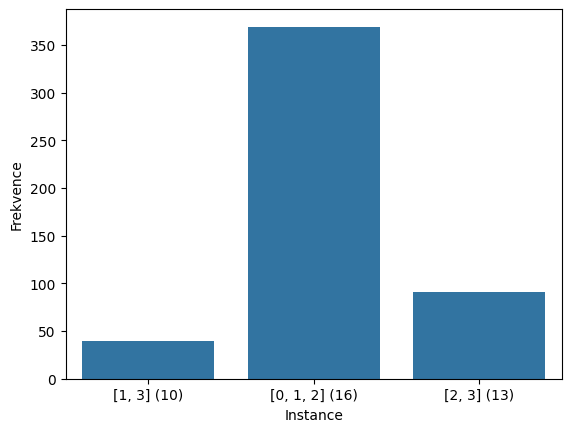

In [254]:
import pandas as pd
import seaborn as sns

# Teď jen pro představu:
history = {}
for _ in range(500):
    idx = GeneticKnapsack(instances, knapsack_capacity).evolution()

    value = sum(map(lambda x: instances[x][2], idx))
    key = f"{str(idx)} ({value})"
    if key in history:
        history[key] += 1
    else:
        history[key] = 1

history_df = pd.DataFrame(list(history.items()), columns=['Instance', 'Frekvence'])

sns.barplot(x=history_df['Instance'], y=history_df['Frekvence'])
pass

In [ ]:
# Pro zájemce o neuroevolution doporučuji navštívit: https://github.com/google/evojax/tree/main/examples